<a href="https://colab.research.google.com/github/cr21/ImageSegmentation/blob/main/CANET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !pip install tensorflow==2.2.0
# !pip install keras==2.3.1
# !pip install -U --pre segmentation-models

In [3]:
# Math functions
# https://en.wikipedia.org/wiki/Generative_adversarial_network
import math
# Image related function from python image library
from PIL import Image, ImageDraw
from PIL import ImagePath
# pandas for data processing
import pandas as pd
# operating system api
import os
from os import path

from os import listdir
from os.path import isfile, join
# to monitor progress of iteration
from tqdm import tqdm
# json data processing
import json
# opencv library version 2
import cv2
# numpy for numerical processing of tensor
import numpy as np
# plotting library
import matplotlib.pyplot as plt
# urllib to get data from url
import urllib
pd.options.display.max_colwidth =1000

# tf.enable_eager_execution()

# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras.layers import Flatten
# split train and test data
from sklearn.model_selection import train_test_split
import tensorflow as tf




# https://arxiv.org/pdf/2002.12041v1.pdf

In [4]:
os.chdir('/content/drive/MyDrive/Dataset/TrafficData/')

In [ ]:
# https://www.jeremyjordan.me/semantic-segmentation/#advanced_unet

In [5]:
ls

data/        model_save_unet/       preprocessed_data.gsheet  uniquelabels.txt
data_df.csv  preprocessed_data.csv  savedModel/               uniqueLabels.txt


In [6]:
#  get preprocessed Images
preprocessed_data = pd.read_csv("preprocessed_data.csv")
preprocessed_data.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [7]:
X_train, X_test = train_test_split(preprocessed_data, test_size=0.20, random_state=21)

In [8]:
print(f"X_train Data shape {X_train.shape}")
print(f"X_test Data shape {X_test.shape}")

X_train Data shape (3206, 3)
X_test Data shape (802, 3)


In [9]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
classes = list(set([filler for filler in label_clr.values()]))

In [10]:
def normalize_image(mask):
    mask = mask/255
    return mask

In [11]:
class Dataset:

    """
      Dataset class This class is useful for data preprocessing and getting items for Data Loader
    """
    

    def __init__(self, data_frame, width, height, classes):
        """
          Initialize the instance variable of class.

          Parameters : 
                data_frame  pandas.DataFrame -> columns : ["Image","Json","mask"]
                width   width of input image
                height  height of input image
                classes : number of output channels we have in our problem and corosponding filler value 
              
        """
        
        self.width  = width
        self.height = height
        self.imagePath = list(data_frame["image"])
        self.maskPath = list(data_frame["mask"])
        self.classValues = sorted(classes)
    
    def __getitem__(self, index):
      """
      Function to get image and output mask at perticular index
      we can also use any augmentation technique here

      Parameters:
        index (int) : index to fetch the data

      return (image, mask) tuple

      """
      # get and read image at index in image path
      image = cv2.imread(self.imagePath[index],cv2.IMREAD_UNCHANGED)
      # resize the image to match with input dimension
      image = cv2.resize(image, (self.width, self.height), interpolation = cv2.INTER_NEAREST)

      # get and read mask at index in mask path
      mask = cv2.imread(self.maskPath[index], cv2.IMREAD_UNCHANGED)
      # resize the mask to match with dimension
      mask  = cv2.resize(mask, (self.width, self.height), interpolation  = cv2.INTER_NEAREST)
      #  we have21 different objects so output channel will be 21
      # https://www.jeremyjordan.me/semantic-segmentation/#advanced_unet
      image_mask_with_outputchannel = [(mask == j) for j in self.classValues]
      image_mask_with_outputchannel = np.stack(image_mask_with_outputchannel, axis = -1).astype('float')
      
      # Augmentation examples code might not be perfect but you could do something similar
      #     a = np.random.uniform()
      #     if a<0.2:
      #         image = image
      #         image_mask = image_mask
      #     elif a<0.4:
      #         image = aug3.augment_image(image)
      #         image_mask = aug3.augment_image(image_mask)
      #     elif a<0.6:
      #         image = aug4.augment_image(image)
      #         image_mask = aug4.augment_image(image_mask)
      #     elif a<0.8:
      #         image = aug5.augment_image(image)
      #         image_mask = image_mask
      #     else:
      #         image = aug6.augment_image(image)
      #         image_mask = aug6.augment_image(image_mask)
              
      return image, image_mask_with_outputchannel
        
    def __len__(self):
        return len(self.imagePath)

In [12]:
class DataLoader(tf.keras.utils.Sequence):
  """
    Data Loader class to generate Batch from Dataset. This class implements tf.keras.utils.sequence instances

  """

  def __init__(self, dataset, batch_size = 1, shuffle = False):
    """
      initialize the parameters for the class.

      parameters :
        
        dataset : Entire Dataset
        batch_size = size of the batch we want to return
        shuffle : if True shuffle the data at the end of each epoch


    """

    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indices = np.arange(len(dataset))

  def __getitem__(self, idx):
    """
    
      Function to get the batch at index idx.
      This will get next avaialbel batch_size set of records
    
    """
    
    # generate the batch data
    # get the next start and End index
    startIndex = idx * self.batch_size
    endIndex = (idx +1)  * self.batch_size
    
    collection  = []
    #  get the  next batch from start to end index
    for j in range(startIndex, endIndex):
      collection.append(self.dataset[j])
    
      #  create a batch by appending ( original Image :( 1920 * 1080 * 3 ), Mask : (1920,1080,21))
      #   [
      #         ( (1920,1080,3), (1920,1080,21) )
      #         ( (1920,1080,3), (1920,1080,21) )
      #         ( (1920,1080,3), (1920,1080,21) )
      #         ( (1920,1080,3), (1920,1080,21) )
      # ]
      
      
    batch = [np.stack(samples, axis=0) for samples in zip(*collection)]
      
    return tuple(batch)

  def __len__(self):
    """
      Get the number of Batch : total number of batch in entire dataset

    """

    return len(self.indices) // self.batch_size

  def on_epoch_end(self):
    """
      Operation to perform at the end of each epoch

      We will shuffle the indices at the end of each epoch

    """
    if self.shuffle:
        self.indices = np.random.permutation(self.indices)


# visualize  Images and Mask

In [13]:
train_dataset = Dataset(X_train, 256, 256, classes)
test_dataset = Dataset(X_test, 256, 256, classes)

train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
test_dataloader = DataLoader(test_dataset,  batch_size = 4, shuffle = True)

In [14]:
randomImage, randomMask = train_dataset[50]


In [15]:
imagesTitle = ["OriginalImage","Mask[0:3]","Mask[3:6]","Mask[6:9]","Mask[9:12]","Mask[12:15]","Mask[15:18]","Mask[18:21]"]
images = []
images.append(randomImage)
# add channel 0: 3  from mask channel
images.append(randomMask[...,0:3].squeeze())
# add channel 3: 6  from mask channel
images.append(randomMask[...,3:6].squeeze())
# add channel 6: 9  from mask channel
images.append(randomMask[...,6:9].squeeze())
# add channel 9: 12  from mask channel
images.append(randomMask[...,9:12].squeeze())
# add channel 12 15 from mask channel
images.append(randomMask[...,12:15].squeeze())
# add channel 15 : 18 from mask channel
images.append(randomMask[...,15:18].squeeze())
# add channel 18: 21 from mask channel
images.append(randomMask[...,18:21].squeeze())

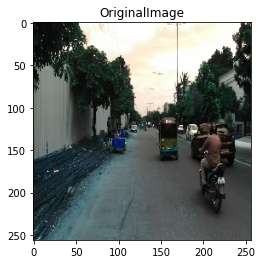

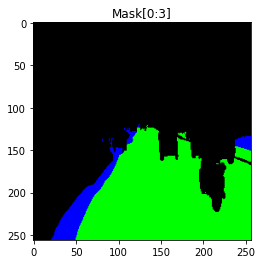

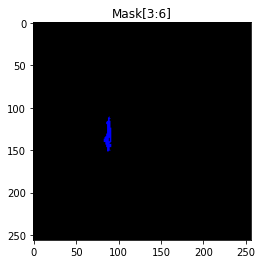

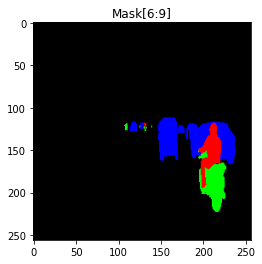

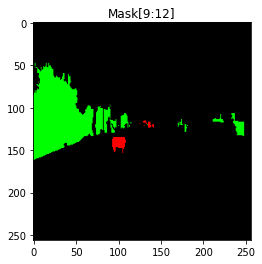

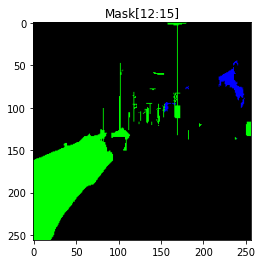

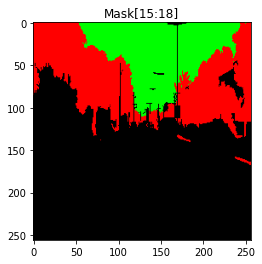

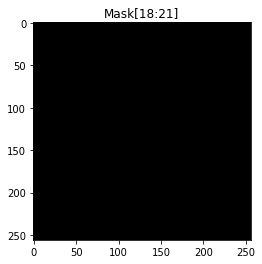

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def process(filename: str=None, title : str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    
    plt.figure()
    plt.title(title)
    plt.imshow(filename)

for idx,file in enumerate(images):
    process(file, imagesTitle[idx])

In [3]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this project we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041v1.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/XHwBlEp.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps  [C_1, C_2, C_3, C_4]
    * C_1 width and heigths are 4x times less than the original image
    * C_2 width and heigths are 8x times less than the original image
    * C_3 width and heigths are 8x times less than the original image
    * C_4 width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [C_1, C_2, C_3, C_4] are formed by applying a "conv block" followed by k number of "identity block". i.e the C_k feature map will single "conv block" followed by k number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/Eu0BM9e.png" width="300"></td>
        <td><img src="https://i.imgur.com/zZkg7zj.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of C_1</strong>: the number filters in the covolutional layers will be [4,4,8] and the number of filters in the parallel conv layer will also be 8.
    * <strong>The conv block and identity block of C_2</strong>: the number filters in the covolutional layers will be [8,8,16] and the number of filters in the parallel conv layer will also be 16.
    * <strong>The conv block and identity block of C_3</strong>: the number filters in the covolutional layers will be [16,16,32] and the number of filters in the parallel conv layer will also be 32.
    * <strong>The conv block and identity block of C_4</strong>: the number filters in the covolutional layers will be [32,32,64] and the number of filters in the parallel conv layer will also be 64.
    * Here + represents the elementwise sum
    <br>
    
 
    
    * Example: if  image is of size (512, 512, 3)
        * the output after C_1 will be 128 * 128 * 8
        * the output after C_2 will be 64 * 64 * 16
        * the output after C_3 will be 64 * 64 * 32
        * the output after C_4 will be 64 * 64 * 64


In [4]:
class convolutional_block(tf.keras.layers.Layer):
    """
      This Block represents the Convolution Block of Encoder Architecture.
      
      Parameters :
        kernel : kernel size 
        filters : list : each list element represents the Filter size in each of the convolution layer in block.
        strides : stride value
        name : name of the current Block

      returns :
        modified Input after series of convolution operation
      
    """


    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        # write the architecutre that was mentioned above
        

        # Convolution Block
        self.conv1 = Conv2D(self.F1, (1,1), (self.stride, self.stride), name="Conv1")
        self.conv2 = Conv2D(self.F2, 3 , padding="same", name="Conv2")
        self.conv3 = Conv2D(self.F3, 1, name="Conv3")
        self.parallelConv = Conv2D(self.F3, 3, (self.stride,self.stride),padding="same", name="ParallelConv")

        # Batch Norms
        self.bn1 = BatchNormalization( name = "BN1" )
        self.bn2 = BatchNormalization( name = "BN2" )
        self.bn3 = BatchNormalization(name = "BN3" )
        self.parallelBN = BatchNormalization(name = "parallelBN" )

        # Activation function
        self.activation = Activation('relu')
        self.add = Add()

    def call(self, X):

        inputVal = X
        # print("InputShape",X.shape)
        # process layers
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.activation(X)
        # print("X.shape",X.shape)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.activation(X)
        # print("InputShape2",X.shape)
        X = self.conv3(X)
        X = self.bn3(X) 
        # print("InputShape",X.shape)
        # get parallel conv block
        parallelX = self.parallelConv(inputVal)
        parallelX = self.parallelBN(parallelX)
        parallelX = self.activation(parallelX)

        # print("X",X.shape)
        # print("para", parallelX.shape)
        #  element wise addition of parallel conv block and normal 3 layer conv block
        X  = self.add((X, parallelX))

        X =  self.activation(X)

        return X

In [5]:
class identity_block(tf.keras.layers.Layer):
    """
      Identity Block of Encoder which follows convolution Block.

      Parameters :
        kernel : kernel size 
        filters : list : each list element represents the Filter size in each of the convolution layer in block.
        strides : stride value
        name : name of the current Block

      returns :
        modified Input after series of convolution operation
      
    """

    def __init__(self, kernel=3,  filters=[4,4,8], name="identity block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        # self.stride = stride

        # write the architecutre that was mentioned above
        
        # Convolution Block
        self.conv1 = Conv2D(self.F1, (1,1), (1, 1), name="IdentityConv1")
        self.conv2 = Conv2D(self.F2, 3 , padding="same", name="IdentityConv2")
        self.conv3 = Conv2D(self.F3, 1, name="IdentityConv3")
        
        # Batch Norms
        self.bn1 = BatchNormalization( name = "IdentityBN1" )
        self.bn2 = BatchNormalization( name = "IdentityBN2" )
        self.bn3 = BatchNormalization(name = "IdentityBN3" )
        

        # Activation function
        self.activation = Activation('relu')
        
        self.add = Add()

    def call(self, X):
        # write the architecutre that was mentioned above

        inputVal = X
        # print("InputShape",X.shape)
        # process layers
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.activation(X)
        # print("X.shape",X.shape)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.activation(X)
        # print("InputShape2",X.shape)
        X = self.conv3(X)
        X = self.bn3(X) 
        # print("InputShape",X.shape)


        X = self.add((X,inputVal))

        X = self.activation(X) 


        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/zYJWFJV.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [21]:
class global_flow(tf.keras.layers.Layer):

    """
      Function to get global context information from Input

        Operation performed in this function
            1) global avg pooling which results in (#, 1, 1, number_of_filters) 
            2) BN, RELU,  
            3) 1∗1 Conv  layer sequentially which results a matrix (#, 1, 1, number_of_filters). 
            4) upsampling / conv2d transpose to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)

        Parameters : 

            width : width of input
            Height : height of input
            filters : filters size
            name : name of block or layer

        returns:
          Context flow which represent the global structure of encoded features
    """

    def __init__(self,  width, height,filters,name="global_flow"):

        super().__init__(name=name)
        
        self.width = width
        self.height = height
        self.filters = filters
        self.globalPooling = GlobalAveragePooling2D()
        self.b1 = BatchNormalization()
        self.activation = Activation('relu')
        self.conv = Conv2D(filters, kernel_size=(1,1), strides =(1,1))
        
        self.transposeConv = Conv2DTranspose(self.filters/2, kernel_size= (self.width, self.height))
        
    def call(self, X):
        # implement the global flow operatiom
        print("Input in Global Flow :", X.shape)

        # apply globalAveragepooling to input

        globalAvg = self.globalPooling(X)
       
        # reshape to (1,1,64)
        globalAvg = Reshape((1,1,self.filters))(globalAvg)
        bn = self.b1(globalAvg)
        activation = self.activation(bn)
        conv_1_1 = self.conv(activation)
        upsampling = self.transposeConv(conv_1_1)
        # print("width : ", self.width)
        # print("filters : ", self.filters)
        # print("filters : ", self.filters)
        return upsampling

In [47]:
class context_flow(tf.keras.layers.Layer):    

    """
        Block for Context Flow, This flow will aggregate the information directly comes from Encoder and upper level flow
        This allows to work with different scale feature maps. 


        Parameters : 

            width : width of input
            Height : height of input
            filters : filters size
            name : name of block or layer

        returns:
          Context flow which aggregates the spatial feature from above flow and global encoded features
          to generate higher contexual features which represents spatial context information at 
          different scale.

    """
    def __init__(self, width, height, filters, name="context_flow"):
        super().__init__(name=name)
        self.width = width
        self.height = height
        self.filters =  filters
        # concate the input on last axis channel concatenation
        self.concatInput = Concatenate(axis=-1)
        self.globalAvgPool = AveragePooling2D()
        self.conv1 = Conv2D(self.filters, kernel_size=(3,3),padding='same')
        self.conv2 = Conv2D(self.filters, kernel_size=(3,3),padding='same')

        self.cf_2_conv_1_1_1 = Conv2D(self.filters,kernel_size=(1,1) )
        self.activation = Activation('relu')
        self.cf_2_conv_1_1_2 = Conv2D(self.filters, kernel_size=(1,1))
        self.sigmoidActivation = Activation('sigmoid')
        self.mult = Multiply()
        self.add = Add()

        self.transposeConv = Conv2DTranspose(32, kernel_size=2,strides=(2, 2))

    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        print("InputShape", INP.shape)
        print("Flow shape", FLOW.shape)

        X = self.concatInput([INP, FLOW])
        X = self.globalAvgPool(X)
        # print("Global Avg (2,2) pool size", X.shape)
        X = self.conv1(X)
        X = self.conv2(X)
        # print("First part of Context Flow Model output shape", X.shape)
        cf_1 = X

        _X = self.cf_2_conv_1_1_1(X)
        # print("context flow 2 (1,1) conv output", _X.shape)
        _X = self.activation(_X)
        # print("context RELU flow 2 activation output", _X.shape)
        _X = self.cf_2_conv_1_1_2(X)
        # print("context flow 2 (1,1) conv output", _X.shape)
        _X = self.sigmoidActivation(_X)
        # print("context SIGMOID flow 2 activation output", _X.shape)

        _X_mult = self.mult((cf_1, _X))
        # print("context _X_mult   output", _X_mult.shape)
        _X_add = self.add((cf_1,_X_mult))
        # print("context _X_add   output", _X_add.shape)
        _X = self.transposeConv(_X_add)

        
        return _X

In [55]:
X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv0',  padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)

X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)
print("++"*50)
# C1 Block 
C1 = convolutional_block(kernel=3, filters= [4,4,8], stride=2,name="C1")(X)
# I1 identity layer
I1 = identity_block(kernel=3, filters=[4,4,8],name = 'I1')(C1)
print("C1 Shape", C1.shape)
print("I1 Shape", I1.shape)
print("++"*50)

# C2 Block 
C2 = convolutional_block(kernel=3, filters= [8,8,16], stride=2,name="C2")(I1)
# I2 identity layer
I2 = identity_block(kernel=3, filters=[8,8,16],name = 'I2')(C2)

print("C2 Shape", C2.shape)
print("I2 Shape", I2.shape)
print("++"*50)

# C3 Block 
C3 = convolutional_block(kernel=3, filters= [16,16,32], stride=1,name="C3")(I2)
# I3 identity layer
I3 = identity_block(kernel=3, filters=[16,16,32],name = 'I3')(C3)

print("C3 Shape", C3.shape)
print("I3 Shape", I3.shape)
print("++"*50)

# C4 Block 
C4 = convolutional_block(kernel=3, filters= [32,32,64], stride=1,name="C4")(I3)
# I4 identity layer
I4 = identity_block(kernel=3, filters=[32,32,64],name = 'I4')(C4)

print("C4 Shape", C4.shape)
print("I4 Shape", I4.shape)
print("++"*50)
# Global Flow
G = global_flow(I4.shape[1], I4.shape[2],I4.shape[3],'global_flow')(I4)
print("Output of Global flow",G.shape)
print("++"*50)
cf1 = context_flow(G.shape[1],G.shape[2], G.shape[3] )([C4, G])
print("Context Flow 1 shape",cf1.shape)
print("++"*50)

cf2 = context_flow(G.shape[1],G.shape[2], G.shape[3] )([C4, cf1])
print("Context Flow 2 shape",cf2.shape)
print("++"*50)

cf3 = context_flow(G.shape[1],G.shape[2], G.shape[3] )([C4, cf2])
print("Context Flow 3 shape",cf3.shape)
print("++"*50)

FsmInput = Add()([G,cf1,cf2,cf3])
print("Feature Selection Module Input shape",FsmInput.shape)
print("++"*50)

(None, 256, 256, 64)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
C1 Shape (None, 128, 128, 8)
I1 Shape (None, 128, 128, 8)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
C2 Shape (None, 64, 64, 16)
I2 Shape (None, 64, 64, 16)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
C3 Shape (None, 64, 64, 32)
I3 Shape (None, 64, 64, 32)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
C4 Shape (None, 64, 64, 64)
I4 Shape (None, 64, 64, 64)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Input in Global Flow : (None, 64, 64, 64)
width :  64
filters :  64
filters :  64
Output of Global flow (None, 64, 64, 32)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
InputShape (None, 64, 64

In [ ]:
# write the complete architecutre

model = Model(inputs = X, outputs = output)

model.summary()

NameError: ignored